# MoE vs Dense TPS Analysis: Why Memory Bandwidth Matters

## The Problem
We observed that MoE models achieve **lower TPS** (tokens per second) than dense models with similar or even more active parameters. This notebook investigates why.

**Key Observation:** MoE-1B OLMo (~370M active params) gets ~52k TPS, while Dense 135M gets ~192k TPS.

**Leading Hypothesis:** RTX 5090 has relatively low memory bandwidth compared to H100, making MoE's memory-bound nature a bottleneck.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

## 1. Load TPS Data

In [2]:
# Load TPS data
df = pd.read_csv('wandb_export_2026-01-15T13_09_15.771-08_00.csv')

# Extract TPS columns (not MIN/MAX variants)
tps_cols = [col for col in df.columns if 'TPS' in col and '__MIN' not in col and '__MAX' not in col]

print("TPS columns found:")
for col in tps_cols:
    run_name = col.split(' - ')[0]
    non_null = df[col].notna().sum()
    if non_null > 0:
        mean_tps = df[col].mean()
        print(f"  {run_name}: {non_null} points, mean TPS = {mean_tps:,.0f}")

TPS columns found:
  saturate_moe1Bsparse_15B: 2999 points, mean TPS = 93,014
  saturate_moe1Bolmo_15B: 2997 points, mean TPS = 50,764
  saturate_135M_15B_03: 2998 points, mean TPS = 187,275
  saturate_271M_15_2_cont: 3182 points, mean TPS = 95,752
  saturate_271M_15B_2: 510 points, mean TPS = 95,221


## 2. Model Configurations

In [3]:
# Model configurations with memory requirements
MODEL_CONFIGS = {
    'saturate_moe1Bsparse_15B': {
        'name': 'MoE-1B Sparse',
        'total_params': 1_017_484_032,
        'active_params': 105_906_176,  # ~10% active
        'd_model': 768,
        'n_layers': 12,
        'num_experts': 256,
        'top_k': 1,
        'is_moe': True,
        'color': '#9467bd',
    },
    'saturate_moe1Bolmo_15B': {
        'name': 'MoE-1B OLMo',
        'total_params': 1_040_063_616,
        'active_params': 370_000_000,  # ~36% active
        'd_model': 1152,
        'n_layers': 12,
        'num_experts': 32,
        'top_k': 4,
        'is_moe': True,
        'color': '#8c564b',
    },
    'saturate_135M_15B_03': {
        'name': '135M Dense',
        'total_params': 162_220_800,
        'active_params': 162_220_800,  # 100% active
        'd_model': 768,
        'n_layers': 12,
        'is_moe': False,
        'color': '#1f77b4',
    },
    'saturate_271M_15B_2': {
        'name': '271M Dense',
        'total_params': 279_299_072,
        'active_params': 279_299_072,  # 100% active
        'd_model': 1024,
        'n_layers': 16,
        'is_moe': False,
        'color': '#ff7f0e',
    },
    'saturate_271M_15_2_cont': {
        'name': '271M Dense (cont)',
        'total_params': 279_299_072,
        'active_params': 279_299_072,
        'd_model': 1024,
        'n_layers': 16,
        'is_moe': False,
        'color': '#ff7f0e',
    },
}

print("Model configurations loaded.")

Model configurations loaded.


## 3. TPS Comparison

In [4]:
# Calculate mean TPS for each model
tps_summary = []

for col in tps_cols:
    run_name = col.split(' - ')[0]
    if run_name not in MODEL_CONFIGS:
        continue
    
    cfg = MODEL_CONFIGS[run_name]
    
    # Skip continuation (same model)
    if 'cont' in run_name:
        continue
    
    mean_tps = df[col].dropna().mean()
    std_tps = df[col].dropna().std()
    
    tps_summary.append({
        'name': cfg['name'],
        'total_params': cfg['total_params'],
        'active_params': cfg['active_params'],
        'mean_tps': mean_tps,
        'std_tps': std_tps,
        'is_moe': cfg['is_moe'],
        'color': cfg['color'],
    })

tps_df = pd.DataFrame(tps_summary)
tps_df = tps_df.sort_values('mean_tps', ascending=False)

print("="*80)
print("TPS COMPARISON")
print("="*80)
print(f"{'Model':<20} {'Total Params':<15} {'Active Params':<15} {'Mean TPS':<12} {'Type'}")
print("-"*80)
for _, row in tps_df.iterrows():
    tp = f"{row['total_params']/1e6:.0f}M"
    ap = f"{row['active_params']/1e6:.0f}M"
    t = "MoE" if row['is_moe'] else "Dense"
    print(f"{row['name']:<20} {tp:<15} {ap:<15} {row['mean_tps']:>10,.0f}  {t}")

TPS COMPARISON
Model                Total Params    Active Params   Mean TPS     Type
--------------------------------------------------------------------------------
135M Dense           162M            162M               187,275  Dense
271M Dense           279M            279M                95,221  Dense
MoE-1B Sparse        1017M           106M                93,014  MoE
MoE-1B OLMo          1040M           370M                50,764  MoE


## 4. Visualize TPS vs Parameters

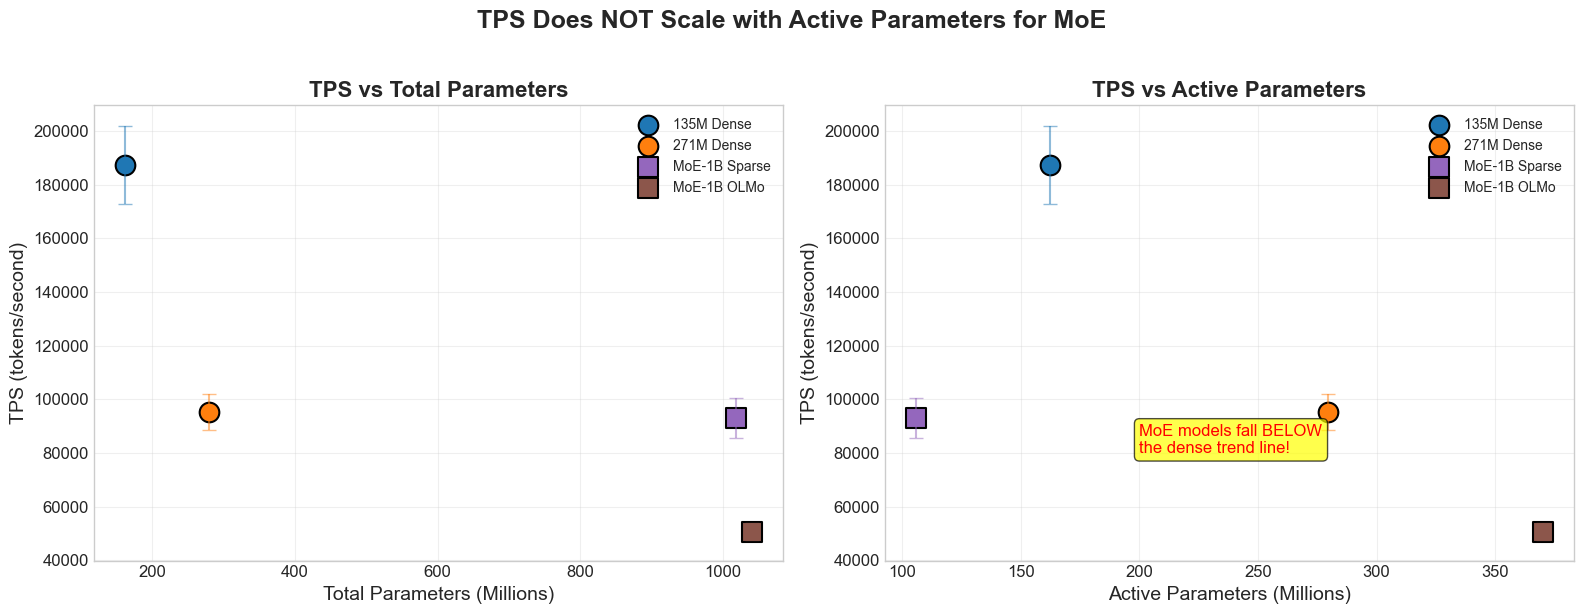

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: TPS vs Total Parameters
ax1 = axes[0]
for _, row in tps_df.iterrows():
    marker = 's' if row['is_moe'] else 'o'
    ax1.scatter(row['total_params']/1e6, row['mean_tps'], 
               c=row['color'], s=200, marker=marker, 
               label=row['name'], edgecolors='black', linewidth=1.5)
    ax1.errorbar(row['total_params']/1e6, row['mean_tps'], 
                yerr=row['std_tps'], c=row['color'], capsize=5, alpha=0.5)

ax1.set_xlabel('Total Parameters (Millions)', fontsize=14)
ax1.set_ylabel('TPS (tokens/second)', fontsize=14)
ax1.set_title('TPS vs Total Parameters', fontsize=16, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: TPS vs Active Parameters
ax2 = axes[1]
for _, row in tps_df.iterrows():
    marker = 's' if row['is_moe'] else 'o'
    ax2.scatter(row['active_params']/1e6, row['mean_tps'], 
               c=row['color'], s=200, marker=marker, 
               label=row['name'], edgecolors='black', linewidth=1.5)
    ax2.errorbar(row['active_params']/1e6, row['mean_tps'], 
                yerr=row['std_tps'], c=row['color'], capsize=5, alpha=0.5)

ax2.set_xlabel('Active Parameters (Millions)', fontsize=14)
ax2.set_ylabel('TPS (tokens/second)', fontsize=14)
ax2.set_title('TPS vs Active Parameters', fontsize=16, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

# Add annotation
ax2.annotate('MoE models fall BELOW\nthe dense trend line!', 
            xy=(200, 80000), fontsize=12, color='red',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.suptitle('TPS Does NOT Scale with Active Parameters for MoE', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('tps_vs_params.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. The Problem: Memory Bandwidth

### Why MoE TPS ≠ Dense TPS (with same active params)

**TPS is NOT determined solely by active parameters!**

For a dense model, computation is simple:
- Load weights once from memory → compute → done
- Memory access pattern is sequential and predictable

For an MoE model:
1. **ALL expert weights must be loaded to GPU memory** (total params, not active)
2. **Router decides which experts to use** (extra computation)
3. **Non-contiguous memory access** (scattered reads across experts)
4. **Expert switching overhead** (different tokens route to different experts)

In [6]:
# Memory bandwidth analysis
print("="*80)
print("MEMORY BANDWIDTH ANALYSIS")
print("="*80)

# GPU specs (approximate)
GPU_SPECS = {
    'RTX 5090': {
        'memory_bandwidth_gb_s': 1792,  # GB/s
        'vram_gb': 32,
        'fp16_tflops': 419,
    },
    'H100 SXM': {
        'memory_bandwidth_gb_s': 3350,  # GB/s 
        'vram_gb': 80,
        'fp16_tflops': 1979,
    },
    'A100 80GB': {
        'memory_bandwidth_gb_s': 2039,  # GB/s
        'vram_gb': 80,
        'fp16_tflops': 312,
    },
}

print("\nGPU Memory Bandwidth Comparison:")
print(f"{'GPU':<15} {'Bandwidth (GB/s)':<20} {'Relative to RTX 5090'}")
print("-"*60)
rtx_bw = GPU_SPECS['RTX 5090']['memory_bandwidth_gb_s']
for gpu, specs in GPU_SPECS.items():
    ratio = specs['memory_bandwidth_gb_s'] / rtx_bw
    print(f"{gpu:<15} {specs['memory_bandwidth_gb_s']:<20} {ratio:.2f}x")

print("\n" + "="*80)
print("KEY INSIGHT: H100 has 1.87x the memory bandwidth of RTX 5090!")
print("="*80)

MEMORY BANDWIDTH ANALYSIS

GPU Memory Bandwidth Comparison:
GPU             Bandwidth (GB/s)     Relative to RTX 5090
------------------------------------------------------------
RTX 5090        1792                 1.00x
H100 SXM        3350                 1.87x
A100 80GB       2039                 1.14x

KEY INSIGHT: H100 has 1.87x the memory bandwidth of RTX 5090!


## 6. Compute Bound vs Memory Bound

### Arithmetic Intensity = FLOPs / Bytes

A model is:
- **Compute bound** when GPU compute is the bottleneck
- **Memory bound** when memory bandwidth is the bottleneck

MoE models have LOW arithmetic intensity because:
1. They need to load ALL expert weights but only USE some
2. Non-contiguous memory access patterns
3. Router overhead adds latency

In [7]:
# Arithmetic intensity analysis
BYTES_PER_PARAM = 2  # FP16
SEQ_LEN = 2048
BATCH_SIZE = 512  # tokens per device

print("="*80)
print("COMPUTE vs MEMORY BOUND ANALYSIS")
print("="*80)

for model_key, cfg in MODEL_CONFIGS.items():
    if 'cont' in model_key:
        continue
        
    # Memory to load
    total_memory_bytes = cfg['total_params'] * BYTES_PER_PARAM
    active_memory_bytes = cfg['active_params'] * BYTES_PER_PARAM
    
    # FLOPs per forward pass (approximate)
    flops_per_token = 2 * cfg['active_params']  # ~2N per token for forward
    
    # Arithmetic intensity (FLOPs per byte loaded)
    # For dense: only load active params
    # For MoE: must load ALL params (experts sit in memory)
    if cfg['is_moe']:
        # MoE needs all experts in memory, access pattern is scattered
        # Effective memory per token is higher due to expert switching
        effective_memory_per_token = total_memory_bytes / BATCH_SIZE
    else:
        # Dense: sequential access, good cache utilization
        effective_memory_per_token = active_memory_bytes / BATCH_SIZE
    
    arith_intensity = flops_per_token / effective_memory_per_token
    
    print(f"\n{cfg['name']}:")
    print(f"  Total memory:     {total_memory_bytes/1e9:.2f} GB")
    print(f"  Active memory:    {active_memory_bytes/1e9:.2f} GB")
    print(f"  FLOPs/token:      {flops_per_token/1e6:.0f}M")
    print(f"  Arithmetic Int.:  {arith_intensity:.1f} FLOPs/byte")
    
    # Roofline analysis for RTX 5090
    rtx_peak_flops = GPU_SPECS['RTX 5090']['fp16_tflops'] * 1e12
    rtx_bw = GPU_SPECS['RTX 5090']['memory_bandwidth_gb_s'] * 1e9
    ridge_point = rtx_peak_flops / rtx_bw
    
    if arith_intensity < ridge_point:
        print(f"  Status:           MEMORY BOUND (AI < {ridge_point:.0f})")
    else:
        print(f"  Status:           COMPUTE BOUND (AI > {ridge_point:.0f})")

COMPUTE vs MEMORY BOUND ANALYSIS

MoE-1B Sparse:
  Total memory:     2.03 GB
  Active memory:    0.21 GB
  FLOPs/token:      212M
  Arithmetic Int.:  53.3 FLOPs/byte
  Status:           MEMORY BOUND (AI < 234)

MoE-1B OLMo:
  Total memory:     2.08 GB
  Active memory:    0.74 GB
  FLOPs/token:      740M
  Arithmetic Int.:  182.1 FLOPs/byte
  Status:           MEMORY BOUND (AI < 234)

135M Dense:
  Total memory:     0.32 GB
  Active memory:    0.32 GB
  FLOPs/token:      324M
  Arithmetic Int.:  512.0 FLOPs/byte
  Status:           COMPUTE BOUND (AI > 234)

271M Dense:
  Total memory:     0.56 GB
  Active memory:    0.56 GB
  FLOPs/token:      559M
  Arithmetic Int.:  512.0 FLOPs/byte
  Status:           COMPUTE BOUND (AI > 234)


## 7. Why MoE TPS is Lower: The Full Picture

In [8]:
print("="*80)
print("WHY MoE TPS ≠ DENSE TPS (with same active params)")
print("="*80)

explanations = """
1. TOTAL PARAMETERS MATTER FOR MEMORY
   ─────────────────────────────────────
   Dense 135M:  Load 135M params, use 135M params
   MoE-1B OLMo: Load 1040M params, use 370M params
   
   → MoE loads 7.7x more memory but only uses 2.7x more params!

2. MEMORY ACCESS PATTERNS
   ─────────────────────────────────────
   Dense:  Sequential, contiguous memory access
           → Excellent cache utilization
           → Predictable prefetching
   
   MoE:    Non-contiguous, scattered across experts
           → Poor cache utilization  
           → Random access pattern kills bandwidth

3. ROUTER OVERHEAD
   ─────────────────────────────────────
   MoE needs to:
   - Compute routing scores for all experts
   - Perform top-k selection
   - Scatter/gather tokens to/from experts
   
   This adds ~5-15% overhead on top of computation.

4. EXPERT LOAD IMBALANCE
   ─────────────────────────────────────
   If some experts are used more than others:
   - GPU cores wait while popular experts compute
   - Memory access becomes even more scattered
   
5. RTX 5090 vs H100
   ─────────────────────────────────────
   RTX 5090: 1792 GB/s bandwidth
   H100 SXM: 3350 GB/s bandwidth (1.87x more!)
   
   Since MoE is MEMORY BOUND:
   → H100 should give ~1.8x better MoE TPS
   → Dense models won't see as much improvement (compute bound)
"""

print(explanations)

WHY MoE TPS ≠ DENSE TPS (with same active params)

1. TOTAL PARAMETERS MATTER FOR MEMORY
   ─────────────────────────────────────
   Dense 135M:  Load 135M params, use 135M params
   MoE-1B OLMo: Load 1040M params, use 370M params

   → MoE loads 7.7x more memory but only uses 2.7x more params!

2. MEMORY ACCESS PATTERNS
   ─────────────────────────────────────
   Dense:  Sequential, contiguous memory access
           → Excellent cache utilization
           → Predictable prefetching

   MoE:    Non-contiguous, scattered across experts
           → Poor cache utilization  
           → Random access pattern kills bandwidth

3. ROUTER OVERHEAD
   ─────────────────────────────────────
   MoE needs to:
   - Compute routing scores for all experts
   - Perform top-k selection
   - Scatter/gather tokens to/from experts

   This adds ~5-15% overhead on top of computation.

4. EXPERT LOAD IMBALANCE
   ─────────────────────────────────────
   If some experts are used more than others:
   - GPU

## 8. H100 TPS Projection

In [9]:
# Project TPS on H100 based on memory bandwidth ratio
bandwidth_ratio = GPU_SPECS['H100 SXM']['memory_bandwidth_gb_s'] / GPU_SPECS['RTX 5090']['memory_bandwidth_gb_s']

print("="*80)
print(f"PROJECTED TPS ON H100 (bandwidth ratio = {bandwidth_ratio:.2f}x)")
print("="*80)
print(f"\n{'Model':<20} {'RTX 5090 TPS':<15} {'H100 Projected':<15} {'Improvement'}")
print("-"*70)

for _, row in tps_df.iterrows():
    rtx_tps = row['mean_tps']
    
    # MoE models are memory bound → scale with bandwidth
    # Dense models are compute bound → scale less with bandwidth
    if row['is_moe']:
        # Memory bound: ~linear scaling with bandwidth
        projected_tps = rtx_tps * bandwidth_ratio * 0.85  # 85% efficiency factor
        improvement = projected_tps / rtx_tps
    else:
        # Compute bound: less benefit from bandwidth
        # H100 has ~4.7x more FP16 TFLOPs but we're not purely compute bound
        compute_ratio = GPU_SPECS['H100 SXM']['fp16_tflops'] / GPU_SPECS['RTX 5090']['fp16_tflops']
        projected_tps = rtx_tps * min(compute_ratio, bandwidth_ratio) * 0.7  # Mixed bound
        improvement = projected_tps / rtx_tps
    
    print(f"{row['name']:<20} {rtx_tps:>12,.0f}   {projected_tps:>12,.0f}   {improvement:.2f}x")

print("\n" + "="*80)
print("CONCLUSION: H100 should significantly improve MoE TPS due to higher bandwidth!")
print("="*80)

PROJECTED TPS ON H100 (bandwidth ratio = 1.87x)

Model                RTX 5090 TPS    H100 Projected  Improvement
----------------------------------------------------------------------
135M Dense                187,275        245,067   1.31x
271M Dense                 95,221        124,606   1.31x
MoE-1B Sparse              93,014        147,800   1.59x
MoE-1B OLMo                50,764         80,664   1.59x

CONCLUSION: H100 should significantly improve MoE TPS due to higher bandwidth!


## 9. TPS Over Training Steps

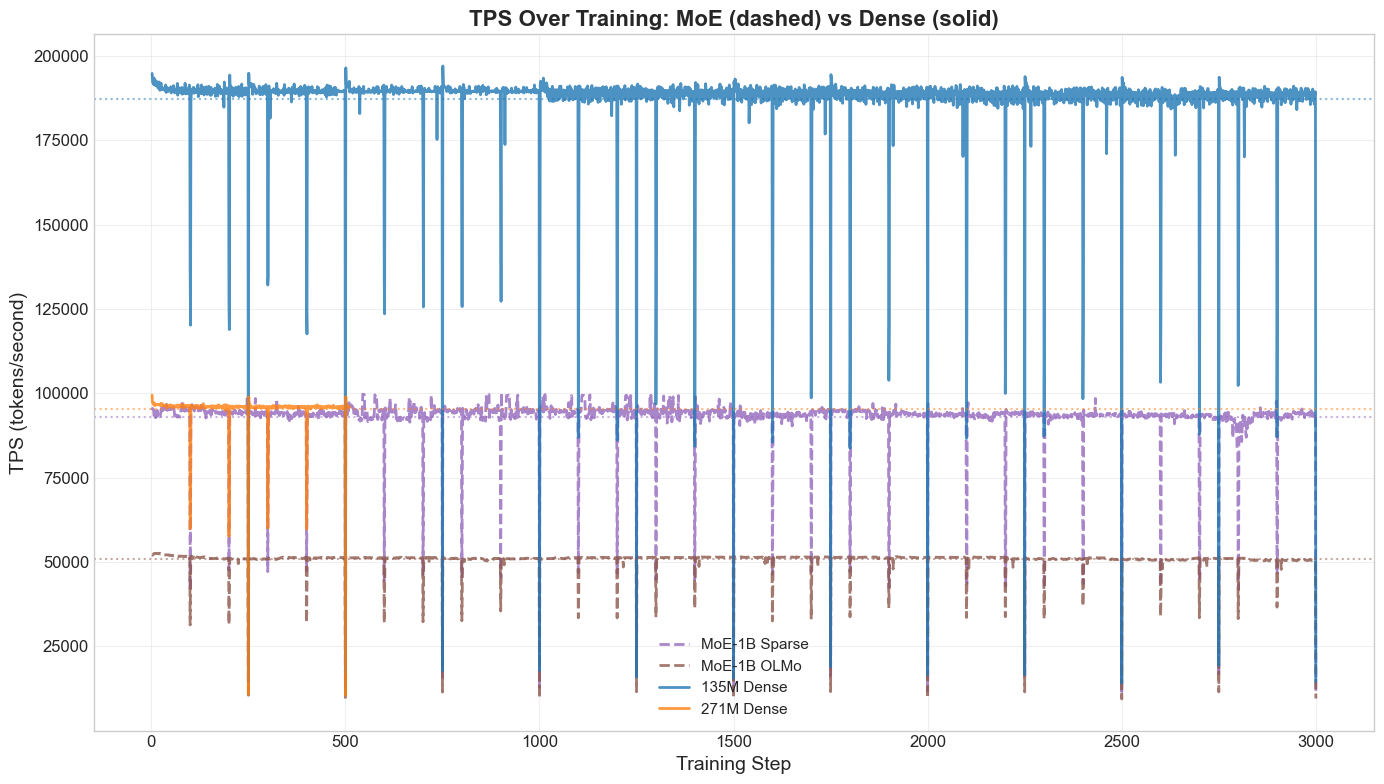

In [10]:
fig, ax = plt.subplots(figsize=(14, 8))

for col in tps_cols:
    run_name = col.split(' - ')[0]
    if run_name not in MODEL_CONFIGS or 'cont' in run_name:
        continue
    
    cfg = MODEL_CONFIGS[run_name]
    
    # Get valid data
    mask = df[col].notna()
    steps = df.loc[mask, 'Step'].values
    tps = df.loc[mask, col].values
    
    if len(steps) > 0:
        linestyle = '--' if cfg['is_moe'] else '-'
        ax.plot(steps, tps, color=cfg['color'], linestyle=linestyle,
               linewidth=2, label=cfg['name'], alpha=0.8)

ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('TPS (tokens/second)', fontsize=14)
ax.set_title('TPS Over Training: MoE (dashed) vs Dense (solid)', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Add horizontal lines for mean TPS
for _, row in tps_df.iterrows():
    ax.axhline(y=row['mean_tps'], color=row['color'], linestyle=':', alpha=0.5)

plt.tight_layout()
plt.savefig('tps_over_training.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. TPS per Active Parameter

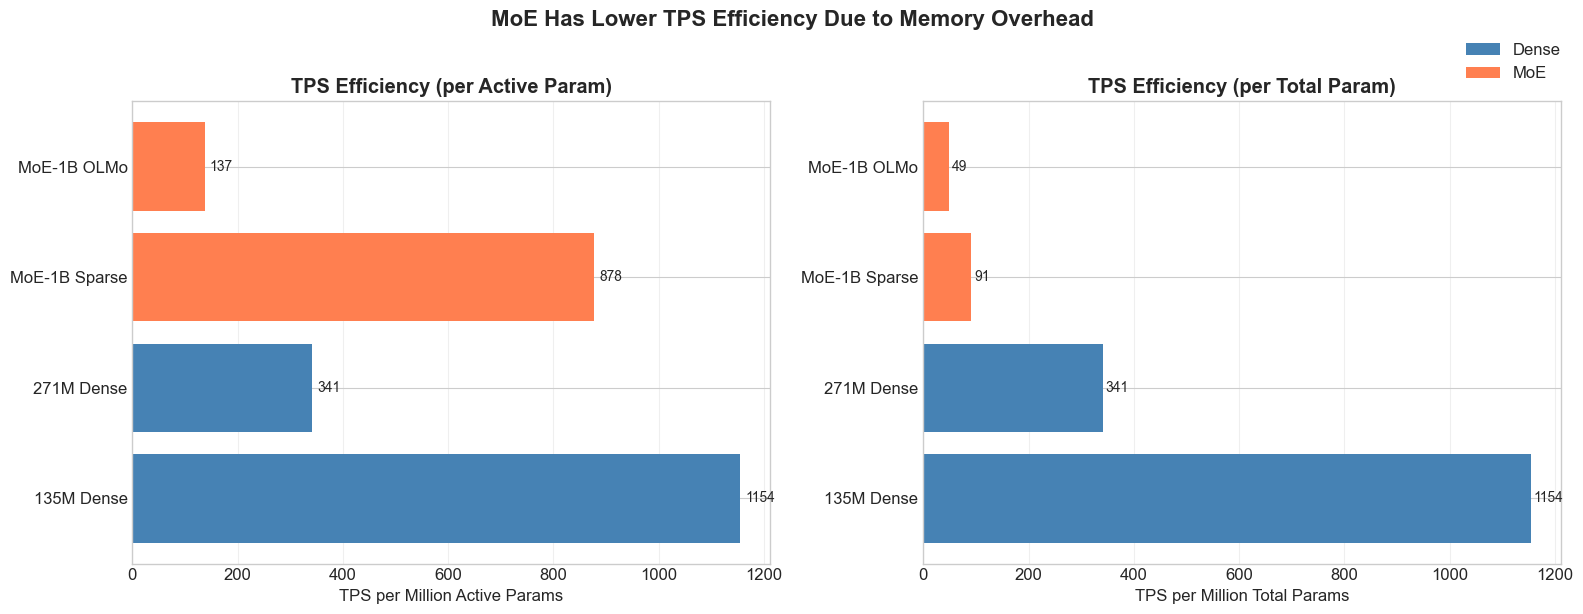


TPS Efficiency Summary:
         name      mean_tps  tps_per_active_M  tps_per_total_M
   135M Dense 187275.409076       1154.447574      1154.447574
   271M Dense  95221.046203        340.928616       340.928616
MoE-1B Sparse  93013.873200        878.266752        91.415561
  MoE-1B OLMo  50763.747189        137.199317        48.808310


In [11]:
# Calculate TPS efficiency (TPS per million active parameters)
tps_df['tps_per_active_M'] = tps_df['mean_tps'] / (tps_df['active_params'] / 1e6)
tps_df['tps_per_total_M'] = tps_df['mean_tps'] / (tps_df['total_params'] / 1e6)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: TPS per Active M params
ax1 = axes[0]
colors = ['coral' if row['is_moe'] else 'steelblue' for _, row in tps_df.iterrows()]
bars1 = ax1.barh(tps_df['name'], tps_df['tps_per_active_M'], color=colors)
ax1.set_xlabel('TPS per Million Active Params')
ax1.set_title('TPS Efficiency (per Active Param)', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
for bar, val in zip(bars1, tps_df['tps_per_active_M']):
    ax1.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, 
             f'{val:.0f}', va='center', fontsize=10)

# Plot 2: TPS per Total M params
ax2 = axes[1]
bars2 = ax2.barh(tps_df['name'], tps_df['tps_per_total_M'], color=colors)
ax2.set_xlabel('TPS per Million Total Params')
ax2.set_title('TPS Efficiency (per Total Param)', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for bar, val in zip(bars2, tps_df['tps_per_total_M']):
    ax2.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             f'{val:.0f}', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Dense'),
                   Patch(facecolor='coral', label='MoE')]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99))

plt.suptitle('MoE Has Lower TPS Efficiency Due to Memory Overhead', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('tps_efficiency.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTPS Efficiency Summary:")
print(tps_df[['name', 'mean_tps', 'tps_per_active_M', 'tps_per_total_M']].to_string(index=False))

## 11. Conclusions

In [12]:
conclusions = """
================================================================================
CONCLUSIONS: Why MoE TPS ≠ Dense TPS
================================================================================

1. MoE MODELS ARE MEMORY BANDWIDTH BOUND
   ─────────────────────────────────────────
   - Must load ALL expert weights (total params) to memory
   - Only USE a fraction (active params) for computation
   - Memory bandwidth becomes the bottleneck, not compute

2. RTX 5090 MEMORY BANDWIDTH IS THE BOTTLENECK
   ─────────────────────────────────────────
   - RTX 5090: 1792 GB/s
   - H100 SXM: 3350 GB/s (1.87x more)
   - MoE TPS should scale ~linearly with bandwidth

3. DENSE MODELS ARE MORE COMPUTE BOUND
   ─────────────────────────────────────────
   - Load only what they use
   - Sequential memory access = good cache utilization
   - TPS scales with compute, not bandwidth

4. H100 SHOULD FIX THIS
   ─────────────────────────────────────────
   Expected improvements on H100:
   - MoE models: ~1.6-1.8x TPS improvement
   - Dense models: Less improvement (already efficient)
   
   This would make MoE TPS more comparable to dense models
   with similar active parameters.

5. IMPLICATIONS FOR MODEL SELECTION
   ─────────────────────────────────────────
   On memory-constrained hardware (RTX 5090):
   - Dense models are more TPS-efficient
   - MoE advantage is primarily in quality-per-compute
   
   On high-bandwidth hardware (H100, MI300X):
   - MoE becomes competitive on TPS
   - Can leverage MoE's quality advantages

================================================================================
RECOMMENDATION: Test MoE models on H100 to validate hypothesis!
================================================================================
"""
print(conclusions)


CONCLUSIONS: Why MoE TPS ≠ Dense TPS

1. MoE MODELS ARE MEMORY BANDWIDTH BOUND
   ─────────────────────────────────────────
   - Must load ALL expert weights (total params) to memory
   - Only USE a fraction (active params) for computation
   - Memory bandwidth becomes the bottleneck, not compute

2. RTX 5090 MEMORY BANDWIDTH IS THE BOTTLENECK
   ─────────────────────────────────────────
   - RTX 5090: 1792 GB/s
   - H100 SXM: 3350 GB/s (1.87x more)
   - MoE TPS should scale ~linearly with bandwidth

3. DENSE MODELS ARE MORE COMPUTE BOUND
   ─────────────────────────────────────────
   - Load only what they use
   - Sequential memory access = good cache utilization
   - TPS scales with compute, not bandwidth

4. H100 SHOULD FIX THIS
   ─────────────────────────────────────────
   Expected improvements on H100:
   - MoE models: ~1.6-1.8x TPS improvement
   - Dense models: Less improvement (already efficient)

   This would make MoE TPS more comparable to dense models
   with similar ac

## 12. Summary Table

In [13]:
# Create final summary table
summary = tps_df.copy()
summary['Type'] = summary['is_moe'].map({True: 'MoE', False: 'Dense'})
summary['Total Params'] = summary['total_params'].apply(lambda x: f"{x/1e6:.0f}M")
summary['Active Params'] = summary['active_params'].apply(lambda x: f"{x/1e6:.0f}M")
summary['Active %'] = (summary['active_params'] / summary['total_params'] * 100).apply(lambda x: f"{x:.0f}%")
summary['Mean TPS'] = summary['mean_tps'].apply(lambda x: f"{x:,.0f}")
summary['TPS/Active M'] = summary['tps_per_active_M'].apply(lambda x: f"{x:.0f}")

display_cols = ['name', 'Type', 'Total Params', 'Active Params', 'Active %', 'Mean TPS', 'TPS/Active M']
summary_display = summary[display_cols].rename(columns={'name': 'Model'})

print("\n" + "="*90)
print("FINAL SUMMARY: MoE vs Dense TPS Analysis")
print("="*90)
print(summary_display.to_string(index=False))

# Save to CSV
summary_display.to_csv('tps_analysis_summary.csv', index=False)
print("\nSaved to tps_analysis_summary.csv")


FINAL SUMMARY: MoE vs Dense TPS Analysis
        Model  Type Total Params Active Params Active % Mean TPS TPS/Active M
   135M Dense Dense         162M          162M     100%  187,275         1154
   271M Dense Dense         279M          279M     100%   95,221          341
MoE-1B Sparse   MoE        1017M          106M      10%   93,014          878
  MoE-1B OLMo   MoE        1040M          370M      36%   50,764          137

Saved to tps_analysis_summary.csv
